# Prevendo consumo de energia elétrica com Redes Neurais Convolucionais

A ideia desse projeto é utilizar redes neurais convolucionais (*Convolutional Neural Network*) para previsão de séries temporais. Na maioria das vezes esse tipo de modelo é usado para modelagem e previsão de imagens, enquanto as redes neurais recorrentes (*RNN's*) são usadas para modelagem e previsão de séries temporais. Entretanto as *CNN's* também pode ser usado para modelagem e previsões temporais de valores contínuos ou de sinais.

Para esse projeto utilizarei uma rede neural convolucional de uma camada da biblioteca *Tensorflow*/*Keras*.

## Importando as bibliotecas.

In [35]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error,median_absolute_error,r2_score

## Dados

O conjunto de dados contém o uso de energia por hora de uma casa de 2 andares localizada em *Houston*, *Texas*, EUA. O conjunto de dados contém o uso de energia por hora em *kwh* começando de 01 de Junho de 2016 até agosto de 2020. O conjunto de dados marcou notas para dias de semana, fins de semana, bloqueio de COVID e dias de férias na coluna de categoria de notas.

O uso de energia durante o dia é diferente do noturno. Os aparelhos elétricos que ficam dentro da casa são câmeras DVR e POI de segurança, 2 geladeiras, 2 esquentadores de 50 galões que ficam ligados durante o dia. À noite várias lâmpadas elétricas, TVs, máquina de lavar, secadora e ar condicionado funcionam das 18h às 8h da manhã.

Os dados podem ser baixados [aqui](https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries?select=power_usage_2016_to_2020.csv).

In [2]:
power = pd.read_csv('power_usage_2016_to_2020.csv')

Visualizando as primeiras linhas da base de dados.

In [3]:
power.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


Visualizando as últimas linhas.

In [4]:
power.tail()

,StartDate,Value (kWh),day_of_week,notes
35947,2020-07-07 19:00:00,1.307,1,weekday
35948,2020-07-07 20:00:00,2.872,1,weekday
35949,2020-07-07 21:00:00,2.138,1,weekday
35950,2020-07-07 22:00:00,2.199,1,weekday
35951,2020-07-07 23:00:00,1.809,1,weekday


Informações sobre a base de dados.

In [5]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


Tabela estatística.

In [6]:
power['Value (kWh)'].describe()

count    35952.000000
mean         0.891631
std          0.908133
min          0.064000
25%          0.323750
50%          0.501000
75%          1.072000
max          6.446000
Name: Value (kWh), dtype: float64

Quantidades de dias da semana

A maior parte são dias de domingos.

In [7]:
power['day_of_week'].value_counts()

1    5184
3    5160
6    5136
2    5136
5    5112
4    5112
0    5112
Name: day_of_week, dtype: int64

A maior parte dos dias são dias de semana, em seguida temos finais de semana, depois o perídos de *lock_down* por conta da pandemia do coronavírus e, por fim, períodos de férias.

In [8]:
power['notes'].value_counts()

weekday           23299
weekend            9215
COVID_lockdown     2305
vacation           1133
Name: notes, dtype: int64

Em relação ao consumo total, os dias de semanas tiveram os maiores resultados, seguidos dos finais de semana.

In [9]:
power.groupby('notes')['Value (kWh)'].sum()

notes
COVID_lockdown     1990.388000
vacation            494.375000
weekday           20801.309639
weekend            8769.851073
Name: Value (kWh), dtype: float64

Entretanto, podemos ver que em relação a média, os períodos que tiveram maior consumo foram os finais de semana.

In [10]:
power.groupby('notes')['Value (kWh)'].mean()

notes
COVID_lockdown    0.863509
vacation          0.436342
weekday           0.892798
weekend           0.951693
Name: Value (kWh), dtype: float64

Os dias que iniciam a semana possuem menores valores médios de consumo de energia e os dias finais, os de maiores consumos. Observa-se que é crescente o consumo médio.

In [11]:
power.groupby('day_of_week')['Value (kWh)'].mean()

day_of_week
0    0.861824
1    0.870365
2    0.866909
3    0.903988
4    0.883665
5    0.919860
6    0.934904
Name: Value (kWh), dtype: float64

Configurando a coluna de datas e horas.

In [12]:
power['StartDate'] = pd.to_datetime(power['StartDate'], format = '%Y-%m-%d %H:%M:%S')

Visualizando graficamente o consumo de energia.

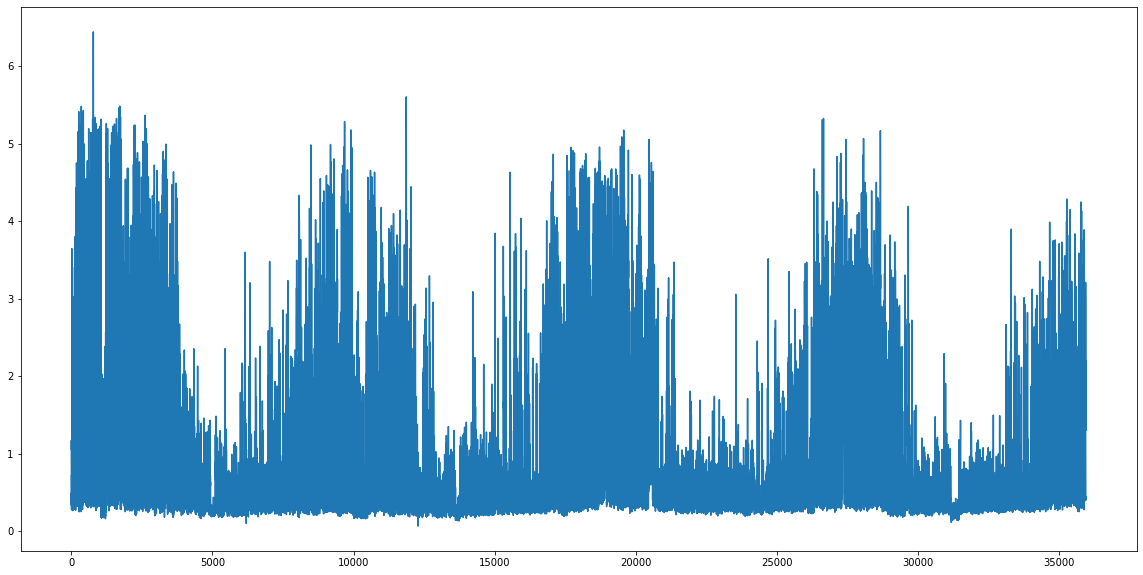

In [13]:
power['Value (kWh)'].plot(figsize=(20,10));

Novamente.

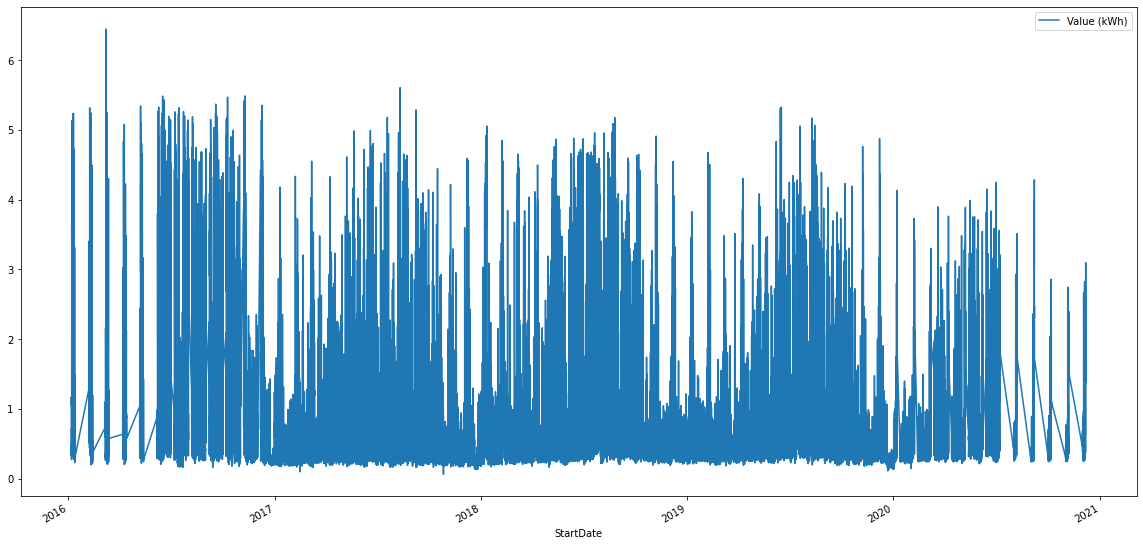

In [14]:
power.plot(x='StartDate', y='Value (kWh)',figsize=(20,10));

## Modelagem dos dados

Para começar a modelagem é necessário, primeiramente, definir as camadas da nossa rede neural convolucional. A primeira camada é a de entrada e onde será definida a convulação da rede neural, que arbitrariamente, defini como 48.



In [15]:
numerical_i = tf.keras.layers.Input((48,1))
numerical = tf.keras.layers.Conv1D(20,4)(numerical_i)
numerical = tf.keras.layers.Flatten()(numerical)
dense = tf.keras.layers.Dense(300,'relu')(numerical)
out=tf.keras.layers.Dense(48,'relu')(dense)

In [16]:
mdl=tf.keras.Model(numerical_i,out)
mdl.compile('adam','mae')
mdl.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 45, 20)            100       
_________________________________________________________________
flatten (Flatten)            (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               270300    
_________________________________________________________________
dense_1 (Dense)              (None, 48)                14448     
Total params: 284,848
Trainable params: 284,848
Non-trainable params: 0
_________________________________________________________________


## Dados de treino e de validação

Agora irei separar uma parte dos dados para treinar o modelo e uma parte que o modelo não irá 'ver' e que usarei para comparar com as previsões que o modelo gerar. Irei definir como dados de treino todas observações anteriores a *01 de Janeiro de 2020* (data que defini de forma arbitrária).

In [17]:
last = pd.to_datetime('2020-01-01')
train = power[power['StartDate']<last]
val = power[power['StartDate']>=last]

Dos dados de treinamento vou separar em duas partes para treinar o modelo.

In [18]:
l=48
h=48

X=[]
Y=[]

for i in range(l,train.shape[0]-h):
  f=train.iloc[i-l:i]['Value (kWh)'].values
  y=train.iloc[i:i+h]['Value (kWh)'].values

  X.append(f)
  Y.append(y)

X=np.array(X)
Y=np.array(Y)

In [19]:
Y.shape

(31320, 48)

In [20]:
X.shape

(31320, 48)

### Treinando a rede neural

Irei definir 10 épocas para treinamento do modelo.

In [21]:
mdl.fit(X,Y,batch_size=1,shuffle=True,epochs=10)

Epoch 1/10
31320/31320 [==============================] - 61s 2ms/step - loss: 0.3832
Epoch 2/10
31320/31320 [==============================] - 61s 2ms/step - loss: 0.3658
Epoch 3/10
31320/31320 [==============================] - 64s 2ms/step - loss: 0.3638
Epoch 4/10
31320/31320 [==============================] - 61s 2ms/step - loss: 0.3627
Epoch 5/10
31320/31320 [==============================] - 61s 2ms/step - loss: 0.3622
Epoch 6/10
31320/31320 [==============================] - 61s 2ms/step - loss: 0.3616
Epoch 7/10
31320/31320 [==============================] - 67s 2ms/step - loss: 0.3612
Epoch 8/10
31320/31320 [==============================] - 62s 2ms/step - loss: 0.3612
Epoch 9/10
31320/31320 [==============================] - 61s 2ms/step - loss: 0.3609
Epoch 10/10
31320/31320 [==============================] - 62s 2ms/step - loss: 0.3606


### Separando dados de validação

In [22]:
Xv=[]
Yv=[]

for i in range(l, val.shape[0]-h):
  f=val.iloc[i-l:i]['Value (kWh)'].values
  y=val.iloc[i:i+h]['Value (kWh)'].values

  Xv.append(f)
  Yv.append(y)

Xv=np.array(Xv)
Yv=np.array(Yv)

### Gerando as previsões do modelo

In [23]:
p=mdl.predict(Xv)

Dimensão da base de validação.

In [24]:
Yv.shape

(4440, 48)

Dimensão da base com as previsões.

In [25]:
p.shape

(4440, 48)

In [26]:
p_base = np.ones(Yv.shape)*np.median(Y,axis=0)

## Métricas de avaliação

Os resultados dos erros estão bem baixos, principalmente o *RMSE* que a métrica de erro mais usada para analisar o desempenho de modelos de séries temporais.

In [38]:
print('Erro médio Absoluto :', mean_absolute_error(Yv,p_base))
print('Erro médio Quadrado :', mean_squared_error(Yv,p_base))
print('Raiz do Erro médio Quadrado :', mean_squared_error(Yv,p_base)**0.5)
print('Logaritmo do Erro médio Quadrado :', mean_squared_log_error(Yv,p_base))
print('Erro mediano Absoluto :', median_absolute_error(Yv,p_base))

Erro médio Absoluto : 0.40716413020172676
Erro médio Quadrado : 0.5030168203753208
Raiz do Erro médio Quadrado : 0.7092367872405666
Logaritmo do Erro médio Quadrado : 0.09906139218343553
Erro mediano Absoluto : 0.19128124999999999


## Comparação gráfica dos resultados

Vemos que as previsões não estão perfeitamente *performadas*, mas de certa forma acompanham bem o comportamento dos valores reais.

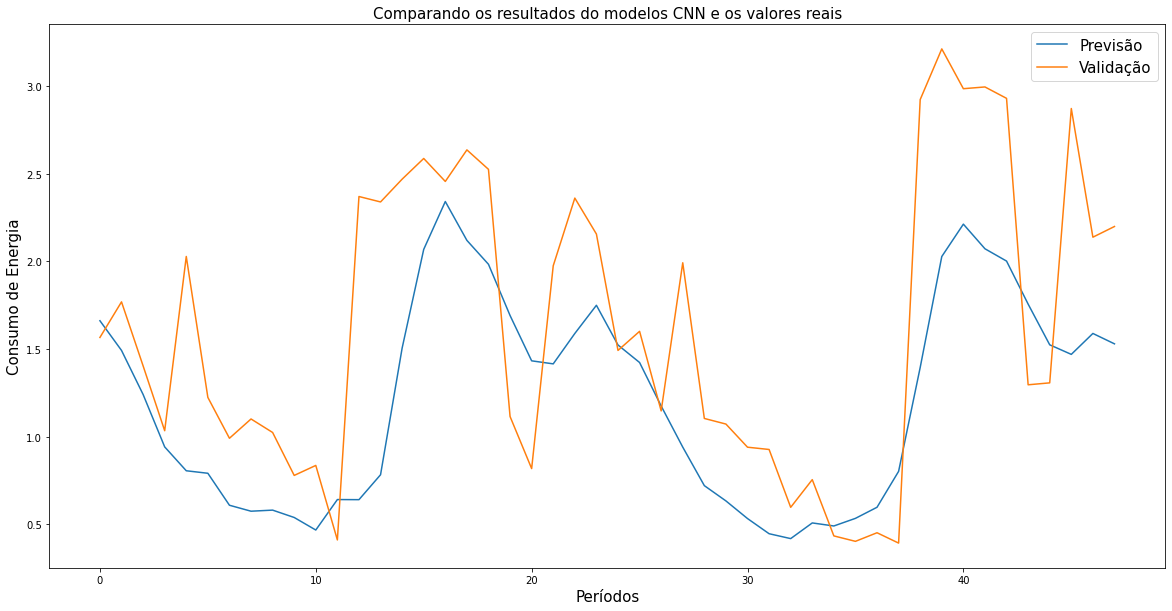

In [30]:
pd.DataFrame({'p':p[4439,:], 'y':Yv[4439,:]}).plot(figsize=(20,10))
plt.title('Comparando os resultados do modelos CNN e os valores reais',size=15)
plt.legend(['Previsão','Validação'],fontsize=15)
plt.xlabel('Períodos',size=15)
plt.ylabel('Consumo de Energia',size=15);

## Conclusão

O foco desse pequeno projeto foi apenas usar um modelo de redes neurais pouco aplicado para problemas de previsão de séries temporais e podemos observar nos resultados anteriores que o desempenho métrico do modelo pode ser considerado satisfatório. Graficamente observamos que as previsões acompanham o movimento dos valores reais.